# PINN for Burger's Equation
Resources:
https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
https://www.mathworks.com/help/deeplearning/ug/solve-partial-differential-equations-using-deep-learning.html
https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=pQhmdtsqZEkj

In [1]:
import numpy as np
import torch

boundary_points = 25 # actually 2*boundary_points, so 50
# boundary conditions
x_b = np.ones(2*boundary_points)
x_b[:boundary_points] = -1*x_b[:boundary_points]
t_b = np.linspace(0, 1, boundary_points)
t_b = np.concatenate((t_b, t_b))
u_b = np.zeros(2*boundary_points)

# inital conditions (t=0) 
initial_points = 50 # initial conditions
t_0 = np.zeros(initial_points)
x_0 = np.linspace(-1, 1, initial_points)
u_0 = -np.sin(x_0*np.pi)

# combine
t_c = np.concatenate((t_b, t_0))
x_c = np.concatenate((x_b, x_0))
u_c = np.concatenate((u_b, u_0))

# collocation points
num = 100
t = np.linspace(0, 1, num)
x = np.linspace(-1, 1, num)
t, x = np.meshgrid(t, x)
t = t.flatten()
x = x.flatten()

# convert to tensor
t = torch.tensor(t, dtype=torch.float)
x = torch.tensor(x, dtype=torch.float)

t_c = torch.tensor(t_c, dtype=torch.float)
x_c = torch.tensor(x_c, dtype=torch.float)
u_c = torch.tensor(u_c, dtype=torch.float)

/home/tarushii/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t_c

tensor([0.0000, 0.0417, 0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333,
        0.3750, 0.4167, 0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083,
        0.7500, 0.7917, 0.8333, 0.8750, 0.9167, 0.9583, 1.0000, 0.0000, 0.0417,
        0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333, 0.3750, 0.4167,
        0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083, 0.7500, 0.7917,
        0.8333, 0.8750, 0.9167, 0.9583, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [3]:
x_c

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000, -1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959,
        -0.7551, -0.7143, -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694,
        -0.4286, -0.3878, -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429,
        -0.1020, -0.0612, -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,
         0.2245,  0.2653,  0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,
         0.5510,  0.5918,  0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,
         0.8776,  0.9184,  0.9592,  1.00

In [4]:
t

tensor([0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000])

In [5]:
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

class NeuralNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(NeuralNet, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        layers = [nn.Linear(in_size, 50)]
        layers.append(nn.Tanh())
        for i in range(10):
            layers.append(nn.Linear(50, 50))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(50, out_size))
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
    def forward(self, t, x):
        inp = torch.stack([t, x], dim=1)
        return self.model(inp)

In [71]:
model = NeuralNet(2, 1)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [73]:
viscosity = 0.01/np.pi

epochs=500

model.train(True)
losses = []
t.requires_grad_(True)
x.requires_grad_(True)
t_c.requires_grad_(True)
x_c.requires_grad_(True)
for i in range(epochs):
    # physics based loss
    u = model(t, x)
    
    dt  = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0] # computes du/dt
    dx  = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0] # computes du/dx
    dx2 = torch.autograd.grad(dx, x, torch.ones_like(dx),  create_graph=True)[0] # computes d^2u/dx^2
    loss_p = torch.sum(torch.square(dt + u.squeeze()*dx - viscosity*dx2))
    #loss_p = torch.tensor([0])
    # conditions loss
    u = model(t_c, x_c)
    loss_c = torch.sum(torch.square(u_c - u.squeeze())) # MSE
    
    loss = loss_p + loss_c
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print("Loss:", loss.item(), "\tInitial Condition Loss:", loss_c.item(), "\tPhysics Loss:", loss_p.item())
    losses.append(loss.item())

Loss: 11.63442325592041 	Initial Condition Loss: 10.497448921203613 	Physics Loss: 1.1369743347167969
Loss: 12.212934494018555 	Initial Condition Loss: 10.507680892944336 	Physics Loss: 1.7052539587020874
Loss: 11.555496215820312 	Initial Condition Loss: 10.484776496887207 	Physics Loss: 1.0707197189331055
Loss: 11.114275932312012 	Initial Condition Loss: 10.487756729125977 	Physics Loss: 0.6265192031860352
Loss: 11.617279052734375 	Initial Condition Loss: 10.503012657165527 	Physics Loss: 1.1142667531967163
Loss: 11.728082656860352 	Initial Condition Loss: 10.49661636352539 	Physics Loss: 1.2314666509628296
Loss: 11.19099235534668 	Initial Condition Loss: 10.49600887298584 	Physics Loss: 0.6949835419654846
Loss: 11.147915840148926 	Initial Condition Loss: 10.488249778747559 	Physics Loss: 0.6596660614013672
Loss: 11.51361083984375 	Initial Condition Loss: 10.474642753601074 	Physics Loss: 1.0389677286148071
Loss: 11.385366439819336 	Initial Condition Loss: 10.461431503295898 	Physics 

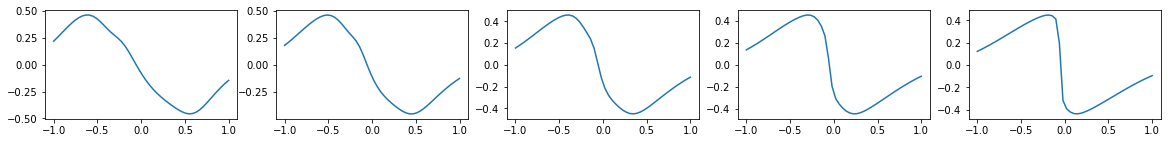

In [95]:
import matplotlib.pyplot as plt

def plot(ax, time):
    u_0_pred = model(torch.tensor(np.full((initial_points), time), dtype=torch.float), torch.tensor(x_0, dtype=torch.float))
    ax.plot(x_0, u_0_pred.detach().numpy())
    
fig, axes = plt.subplots(1, 5, figsize=(20, 2))

for i in range(5):
    plot(axes[i], 0.25*i)
